In [33]:
# NN libraries
import torch
import torch.nn as nn

# Libraries for solving PDE numerically and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized
from scipy.optimize import fsolve

In [34]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

def sin(x):
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

def exp(x):
    if isinstance(x, torch.Tensor): 
        return torch.exp(x)
    else:
        return np.exp(x)

from pathlib import Path
# Create used directories
directories = ["gifs", "PINN_Plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")


Directory 'gifs' is present. ✅
Directory 'PINN_Plots' is present. ✅


In [35]:
# Define PDE Parameters
xi, xf, dx = 0, 1, 1e-2
ti, tf, dt = 0, 2, 1e-3

c  = 1

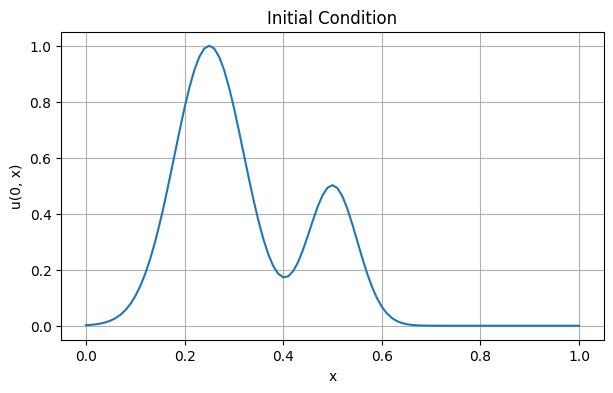

In [36]:
# Initial conditions

x = np.arange(xi, xf + dx, dx, dtype=np.float32)
t = np.arange(ti, tf + dt, dt, dtype=np.float32)
Nx, Nt = len(x), len(t)

def u0(x):
    return np.exp(-100*(x-xf/4)**2) + np.exp(-200*(x-xf/2)**2)*0.5

def v0(x):
    return np.zeros_like(x)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, u0(x))
ax.set_xlabel('x')
ax.set_ylabel('u(0, x)')
ax.set_title('Initial Condition')
ax.grid()
plt.show()

In [37]:
# Create matricies for solving PDE
u = np.zeros((Nt, Nx))
v = np.zeros((Nt, Nx))

def D_t():
    d = 1/(12*dx)
    D = d * diags([1, -8, 0, 8, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [d, -8*d]
    D[1, [-1]] = [d]
    D[-1, [0, 1]] = [8*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)

def D2_t():
    d = 1/(dx**2 * 12)
    D = d * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-d, 16*d]
    D[1, [-1]] = [-d]
    D[-1, [0, 1]] = [16*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)

D1 = D_t()
D2 = D2_t()
c  = 1
I  = diags([1], [0], shape=(Nx, Nx))
A = (I - ((c**2)*dt/2)**2 * D2)
B = (I + ((c**2)*dt/2)**2 * D2)
solve_u = factorized(A.tocsc())

Time 0.000s, max(u) = 1.000
Time 0.001s, max(u) = 1.000
Time 0.002s, max(u) = 1.000
Time 0.003s, max(u) = 0.999
Time 0.004s, max(u) = 0.998
Time 0.005s, max(u) = 0.998
Time 0.006s, max(u) = 0.996
Time 0.007s, max(u) = 0.995
Time 0.008s, max(u) = 0.994
Time 0.009s, max(u) = 0.992
Time 0.010s, max(u) = 0.990
Time 0.011s, max(u) = 0.988
Time 0.012s, max(u) = 0.986
Time 0.013s, max(u) = 0.983
Time 0.014s, max(u) = 0.981
Time 0.015s, max(u) = 0.978
Time 0.016s, max(u) = 0.975
Time 0.017s, max(u) = 0.972
Time 0.018s, max(u) = 0.968
Time 0.019s, max(u) = 0.965
Time 0.020s, max(u) = 0.961
Time 0.021s, max(u) = 0.957
Time 0.022s, max(u) = 0.953
Time 0.023s, max(u) = 0.949
Time 0.024s, max(u) = 0.944
Time 0.025s, max(u) = 0.939
Time 0.026s, max(u) = 0.935
Time 0.027s, max(u) = 0.930
Time 0.028s, max(u) = 0.925
Time 0.029s, max(u) = 0.919
Time 0.030s, max(u) = 0.914
Time 0.031s, max(u) = 0.908
Time 0.032s, max(u) = 0.903
Time 0.033s, max(u) = 0.897
Time 0.034s, max(u) = 0.891
Time 0.035s, max(u) 

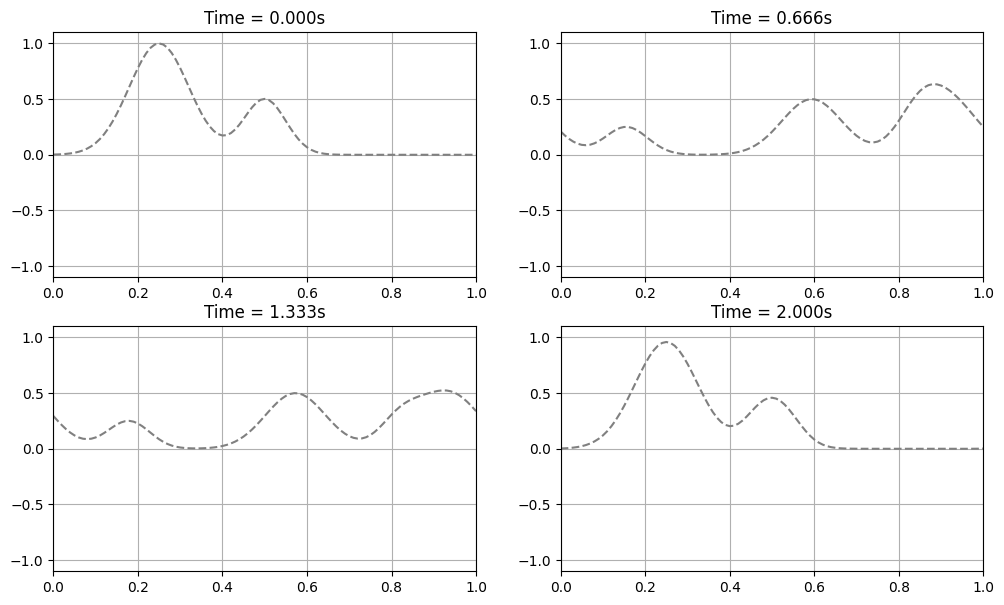

In [38]:
# Numerically Solve PDE wth Crank-Nicolson method

for j, tj in enumerate(t):
    if j == 0:
        u[0, :] = u0(x)    
        v[0, :] = v0(x)
    else:
        k  = j-1
        uk = u[k, :]
        vk = v[k, :] 
        tk = t[k]
        u[j, :] = solve_u(B@uk - (c**2)*dt*D1@vk)
        v[j, :] = vk - ((c**2)*dt/2)*(D1@u[j, :] + D1@uk)
    
    if np.max(np.abs(u[j, :])) > 1e2:
        print(f"Blow up at time {ti:.3f}s")
        break
    
    if j % 1 == 0:
        print(f"Time {tj:.3f}s, max(u) = {np.max(np.abs(u[j, :])):.3f}")


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
for j, ax in enumerate(axs.flat):
    tj = time_indecies[j]
    ax.plot(x, u[tj, :], c="gray", linestyle='--')
    ax.set_title(f"Time = {t[tj]:.3f}s")
    ax.grid()
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(xi, xf)

plt.show()

In [39]:
def training_plot(save=False, file_name=""):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
    time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
    for j, ax in enumerate(axs.flat):
        tj = time_indecies[j]
        ax.plot(x, p[tj, :], c='blue')
        ax.plot(x, u[tj, :], c="gray", linestyle='--')
        ax.set_title(f"Time = {t[tj]:.2f}s")
        ax.grid()
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(xi, xf)
        ax.scatter(boundary1_domain[0, 1], u[tj, 0], s=20, color="purple")
        ax.scatter(boundary2_domain[0, 1], u[tj, -1], s=20, color="purple", label="Boundary Condition")
        ax.scatter(x_col, torch.zeros_like(x_col), color="green", label="Colocation Points", s=5)
    
    axs[0, 0].scatter(initial_x, u0(initial_x), color="red", s=10, label="Initial Condition")
    axs[0, 1].scatter(x_data, u[time_indecies[1], x_indecies], color="black", s=10, label="Training Data")
    fig.suptitle(f"Epoch: {i}")
    axs[0,0].legend()
    axs[0,1].legend()
    
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [40]:
# Define PINN architecture

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [41]:
# Define PINN Hyperparameters

learning_rate = 5e-2
epochs        = 20_000 + 1
weights = [w_initial, w_data, w_boundary, w_PDE] = [1e0, 1e0, 1e0, 1e0]

N_initial  = 50
N_boundary = 50
N_training_t = 20
N_training_x = 20
N_col      = 50

N_layers = 6
N_nodes  = 64

In [42]:
# Domain for initial condition
initial_x = torch.linspace(xi, xf, N_initial)
initial_t = torch.zeros(N_initial)
initial_domain = torch.stack((initial_t, initial_x), dim=1)
initial_u = u0(initial_x).view(-1,1)

# Domain for boundary condition
boundary1_domain = torch.stack((torch.linspace(ti, tf, N_boundary),  x[0]*torch.ones(N_boundary)), dim=1)
boundary2_domain = torch.stack((torch.linspace(ti, tf, N_boundary), x[-1]*torch.ones(N_boundary)), dim=1)

# Domain for training data
t_indecies = torch.linspace(1, (Nt-1)//3, N_training_t, dtype=int) # Defined in terms of indecies to make getting u and corresponding (t,x) values easier
x_indecies = torch.linspace(1, Nx-1, N_training_x, dtype=int)
Ti_mat, Xi_mat = torch.meshgrid(t_indecies, x_indecies, indexing='ij')

t_data = (torch.from_numpy(t))[t_indecies]
x_data = (torch.from_numpy(x))[x_indecies]
Td, Xd = torch.meshgrid(t_data, x_data, indexing='ij')
training_domain = torch.stack((Td.flatten(), Xd.flatten()), dim=1) # (t, x) values that correspond to the u values used for training
training_u      = torch.from_numpy(u)[Ti_mat, Xi_mat].view(-1,1)   # Values of u used in training

# Domain for collocation points
t_col  = torch.linspace(ti, tf, N_col)
x_col  = torch.linspace(xi, xf, N_col)
Tc, Xc = torch.meshgrid(t_col, x_col, indexing='ij')
colocation_domain = torch.stack((Tc.flatten(), Xc.flatten()), dim=1).requires_grad_(True)

# Domain for Error calculation
T, X = torch.meshgrid(torch.from_numpy(t), torch.from_numpy(x), indexing='ij')
input_Domain = torch.stack((T.flatten(), X.flatten()), dim=1)

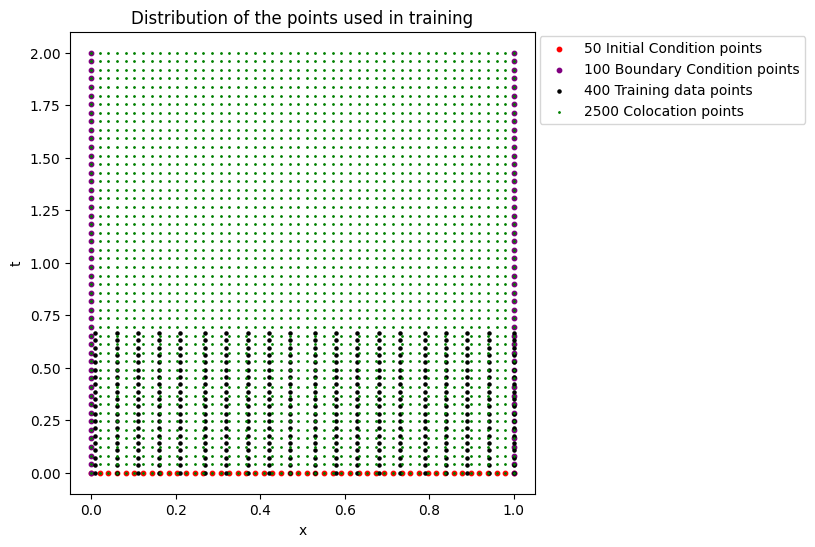

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(initial_x, initial_t, s=10, color="Red", label=f"{N_initial} Initial Condition points")
ax.scatter(boundary1_domain[:,1], boundary1_domain[:,0], s=10, color="purple")
ax.scatter(boundary2_domain[:,1], boundary2_domain[:,0], s=10, color="purple", label=f"{2*N_boundary} Boundary Condition points")
ax.scatter(training_domain[:,1], training_domain[:,0], s= 5, color="black", label=f"{len(training_domain)} Training data points")
ax.scatter(colocation_domain.detach()[:,1], colocation_domain.detach()[:,0], s=1, color="green", label=f"{N_col**2} Colocation points", zorder=1)
ax.legend(loc=(1.01, 0.8))
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Distribution of the points used in training")
plt.show()

Epoch: 0, Loss: 3.7308e-01, MSE = 5.9365e+00, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00


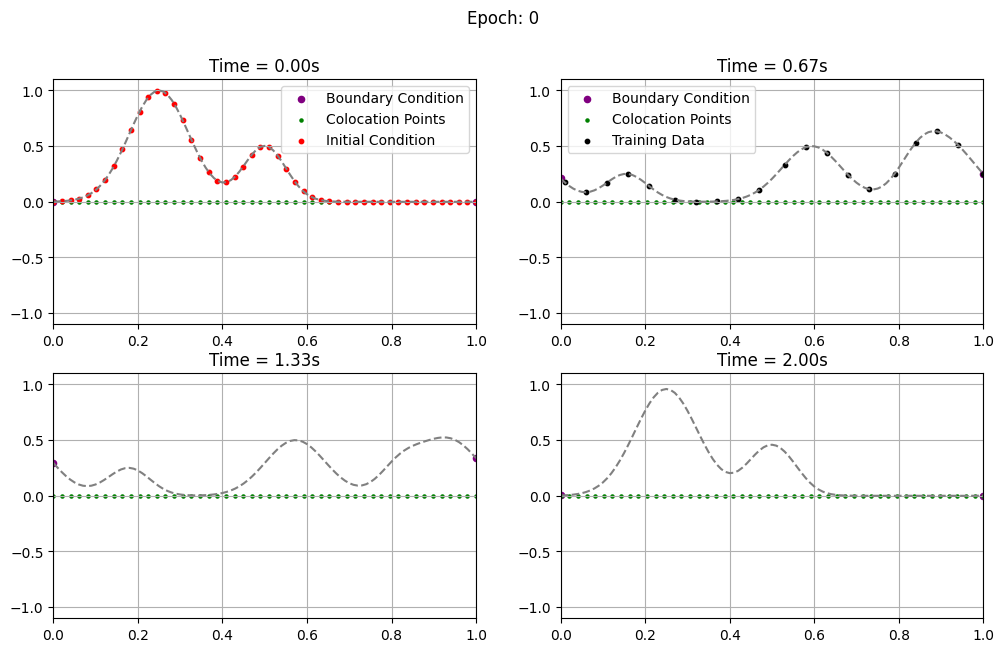

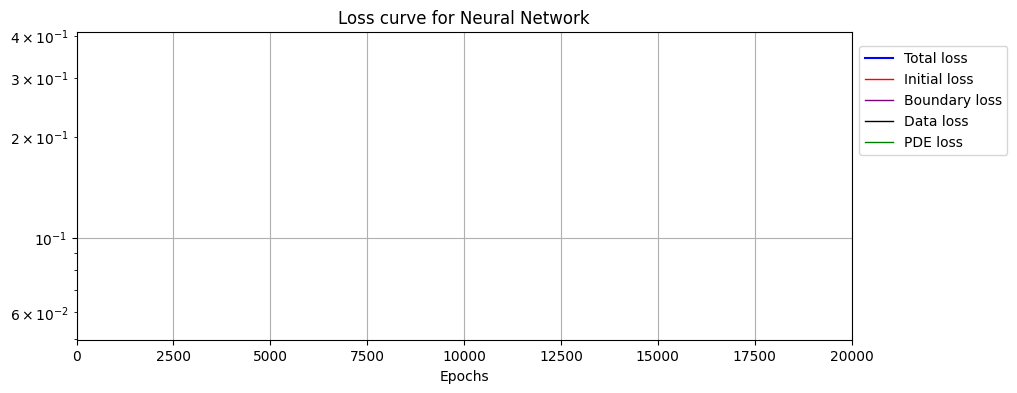

Epoch: 100, Loss: 1.3896e-01, MSE = 4.5529e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 200, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 300, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 400, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 500, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 600, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 700, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 800, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 900, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 5.0000e-02, PDE weight = 1.0000e+00
Epoch: 1000, Loss: 1.3891e-01, MSE = 4.5179e-02, Learning rate = 3.5000e-02, PDE weight = 1.0000e+00

In [ ]:
# Neural Network without physics

Diffusion_PINN = FCN(2, 1, N_nodes, N_layers) # 2 inputs and 1 output since u: RxR -> R, u: (t,x)|->u(t,x)
optimizer      = torch.optim.Adam(Diffusion_PINN.parameters(), lr=learning_rate) # Using the Adam optimizer
scheduler      = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7) 

mse_history  = []
loss_history = []
pde_loss_history  = []
data_loss_history = []
initial_loss_history = []
boundary_loss_history = []


for i in range(epochs):
    Diffusion_PINN.train()
    optimizer.zero_grad()
    
    # Initial Loss
    initial_p    = Diffusion_PINN(initial_domain)
    loss_initial = torch.mean((initial_p - initial_u)**2)
    
    # Boundary Loss
    boundary1_p = Diffusion_PINN(boundary1_domain)
    boundary2_p = Diffusion_PINN(boundary2_domain)
    loss_boundary = torch.mean((boundary1_p - boundary2_p)**2)
    
    # Data Loss
    s = Diffusion_PINN(training_domain)
    loss_data = torch.mean((s - training_u)**2)
    
    # Physics Loss
    v  = Diffusion_PINN(colocation_domain)
    Dv = torch.autograd.grad(v, colocation_domain, torch.ones_like(v), create_graph=True)[0]
    
    v_t  = Dv[:, 0:1]
    v_x  = Dv[:, 1:2]
    
    Dv_x = torch.autograd.grad(v_x, colocation_domain, torch.ones_like(v_x), create_graph=True)[0]
    v_xx = Dv_x[:, 1:2]
    
    Dv_t = torch.autograd.grad(v_t, colocation_domain, torch.ones_like(v_t), create_graph=True)[0]
    v_tt = Dv_t[:, 0:1]
    
    loss_PDE = torch.mean((v_tt - (c**2)*v_xx)**2)

    # Total Loss
    losses  = [loss_initial.item(), loss_data.item(), loss_boundary.item(), loss_PDE.item()]
    
    loss = weights[0]*loss_initial + weights[1]*loss_data + weights[2]*loss_boundary + weights[3]*loss_PDE
    
    loss.backward()
    optimizer.step()
    if (i + 1)%1_000==0:
        scheduler.step()

    
    Diffusion_PINN.eval()
    
    # Finds the Mean Squared Error with the real solution
    P = Diffusion_PINN(input_Domain).detach()
    p = P.numpy().reshape(Nt, Nx)
    MSE = np.mean((u - p)**2)
    
    loss_history.append(loss.item())
    initial_loss_history.append(losses[0])
    data_loss_history.append(losses[1])
    boundary_loss_history.append(losses[2])
    pde_loss_history.append(losses[3])
    
    if i % 100 == 0:
        print(f"Epoch: {i}, Loss: {loss.item():.4e}, MSE = {MSE:.4e}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}, PDE weight = {w_PDE:.4e}")
        if i % 5000 == 0:
            training_plot()
            plt.show()
            fig, ax = plt.subplots(figsize=(10, 4))
            lw = 1
            ax.set_title("Loss curve for Neural Network")
            ax.plot(loss_history, label="Total loss", c="blue")
            ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
            ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
            ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
            ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
            ax.set_xlabel("Epochs")
            ax.set_yscale("log")
            ax.set_xlim(0, epochs)
            ax.legend(loc=(1.01, 0.6))
            ax.grid()
            plt.show()

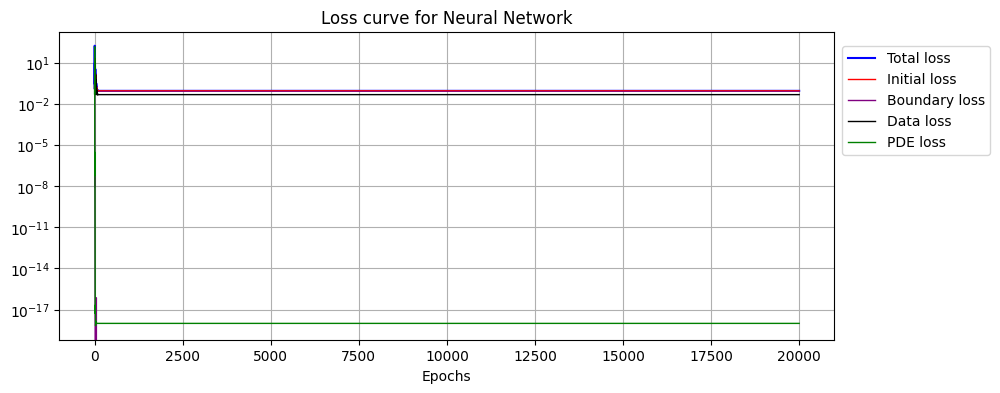

In [ ]:
lw = 1
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Loss curve for Neural Network")
ax.plot(loss_history, label="Total loss", c="blue")
ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
ax.set_xlabel("Epochs")
ax.set_yscale("log")
ax.legend(loc=(1.01, 0.6))
ax.grid()
plt.show()

In [ ]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", tk=0):
    fig, ax = plt.subplots()
    ax.plot(x, u[index, :], label='Numerical Solution Solution', linestyle='--', c="black")
    ax.plot(x, p[index, :], label='PINN Solution', c="blue")
    ax.set_xlim(xi, xf)
    ax.set_ylim(-1.05, 1.05)
    ax.grid()
    ax.set_title(f"Time = {tk:.3f}s")
    ax.legend()
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [ ]:
import os
import shutil

folder_path="PINN_plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [ ]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, 2*int(fps*t[-1]), dtype=int)
N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"PINN_plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, tk=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("gifs/Burgers_PINN_Comparison.gif", files, fps=fps, loop=0)

0/80
1/80
2/80
3/80
4/80
5/80
6/80
7/80
8/80
9/80
10/80
11/80
12/80
13/80
14/80
15/80
16/80
17/80
18/80
19/80
20/80
21/80
22/80
23/80
24/80
25/80
26/80
27/80
28/80
29/80
30/80
31/80
32/80
33/80
34/80
35/80
36/80
37/80
38/80
39/80
40/80
41/80
42/80
43/80
44/80
45/80
46/80
47/80
48/80
49/80
50/80
51/80
52/80
53/80
54/80
55/80
56/80
57/80
58/80
59/80
60/80
61/80
62/80
63/80
64/80
65/80
66/80
67/80
68/80
69/80
70/80
71/80
72/80
73/80
74/80
75/80
76/80
77/80
78/80
79/80
